# Loop 4 Analysis - Strategy Assessment

## Key Observations:
1. Current best: 70.676145 (verified ensemble)
2. Target: 68.922808
3. Gap: 1.75 points (2.5% reduction needed)
4. Current LB #1: 71.19 (terry_u16)
5. **Our target is BETTER than the current #1 on the leaderboard!**

In [1]:
import pandas as pd
import numpy as np
import os
import glob

# List all available CSV sources
print('=== Available Sources ===')
for path in glob.glob('/home/code/datasets/**/*.csv', recursive=True):
    print(path)

=== Available Sources ===
/home/code/datasets/submission.csv
/home/code/datasets/santa-2025.csv
/home/code/datasets/72.49.csv
/home/code/datasets/71.97.csv
/home/code/datasets/chistyakov_kernel_output/submission.csv
/home/code/datasets/chistyakov_output/submission.csv
/home/code/datasets/telegram/72.49.csv
/home/code/datasets/telegram/71.97.csv
/home/code/datasets/jazivxt_output/submission.csv
/home/code/datasets/bucket-of-chump/submission.csv
/home/code/datasets/ashraful_output/submission.csv
/home/code/datasets/saspav/santa-2025.csv
/home/code/datasets/saspav_dataset/santa-2025.csv
/home/code/datasets/chistyakov/submission_best.csv
/home/code/datasets/chistyakov_packed/submission_best.csv
/home/code/datasets/eazy_output/submission.csv
/home/code/datasets/egortrushin_output/submission.csv


In [2]:
# Check the jonathanchan kernel for the C++ optimizer
print('=== jonathanchan kernel files ===')
for f in os.listdir('/home/code/research/kernels/jonathanchan_santa25-ensemble-sa-fractional-translation'):
    print(f)

=== jonathanchan kernel files ===
santa25-ensemble-sa-fractional-translation.ipynb
kernel-metadata.json


In [3]:
# Check if we have the sa_v1_parallel.cpp file
sa_cpp_path = '/home/code/research/kernels/jonathanchan_santa25-ensemble-sa-fractional-translation/sa_v1_parallel.cpp'
if os.path.exists(sa_cpp_path):
    print('sa_v1_parallel.cpp exists!')
    with open(sa_cpp_path, 'r') as f:
        content = f.read()
        print(f'File size: {len(content)} bytes')
else:
    print('sa_v1_parallel.cpp NOT FOUND')

sa_v1_parallel.cpp NOT FOUND


In [4]:
# Check what optimizers we have compiled
print('=== Compiled optimizers ===')
for path in ['/home/code/datasets/bbox3', '/home/code/datasets/bucket-of-chump/bbox3']:
    if os.path.exists(path):
        print(f'{path} exists, size: {os.path.getsize(path)} bytes')

=== Compiled optimizers ===
/home/code/datasets/bbox3 exists, size: 118704 bytes
/home/code/datasets/bucket-of-chump/bbox3 exists, size: 96128 bytes


In [5]:
# Analyze the current submission score breakdown by N
import math

def score_group_simple(xs, ys, degs):
    TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
    TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])
    n = len(xs)
    mnx = mny = 1e300
    mxx = mxy = -1e300
    for i in range(n):
        r = degs[i] * math.pi / 180.0
        c, s = math.cos(r), math.sin(r)
        xi, yi = xs[i], ys[i]
        for j in range(15):
            X = c * TX[j] - s * TY[j] + xi
            Y = s * TX[j] + c * TY[j] + yi
            if X < mnx: mnx = X
            if X > mxx: mxx = X
            if Y < mny: mny = Y
            if Y > mxy: mxy = Y
    side = max(mxx - mnx, mxy - mny)
    return side * side / n

def strip(val):
    return float(str(val).replace('s', ''))

# Load current submission
df = pd.read_csv('/home/submission/submission.csv')
df['N'] = df['id'].str.split('_').str[0].astype(int)

scores = []
for n in range(1, 201):
    group = df[df['N'] == n]
    xs = np.array([strip(x) for x in group['x']])
    ys = np.array([strip(y) for y in group['y']])
    degs = np.array([strip(d) for d in group['deg']])
    sc = score_group_simple(xs, ys, degs)
    scores.append({'N': n, 'score': sc})

scores_df = pd.DataFrame(scores)
print(f'Total score: {scores_df["score"].sum():.6f}')
print(f'\nTop 10 worst N values (highest score contribution):')
print(scores_df.nlargest(10, 'score'))

Total score: 70.676145

Top 10 worst N values (highest score contribution):
     N     score
0    1  0.661250
1    2  0.450779
2    3  0.434745
4    5  0.416850
3    4  0.416545
6    7  0.399897
5    6  0.399610
8    9  0.387415
7    8  0.385407
14  15  0.379203


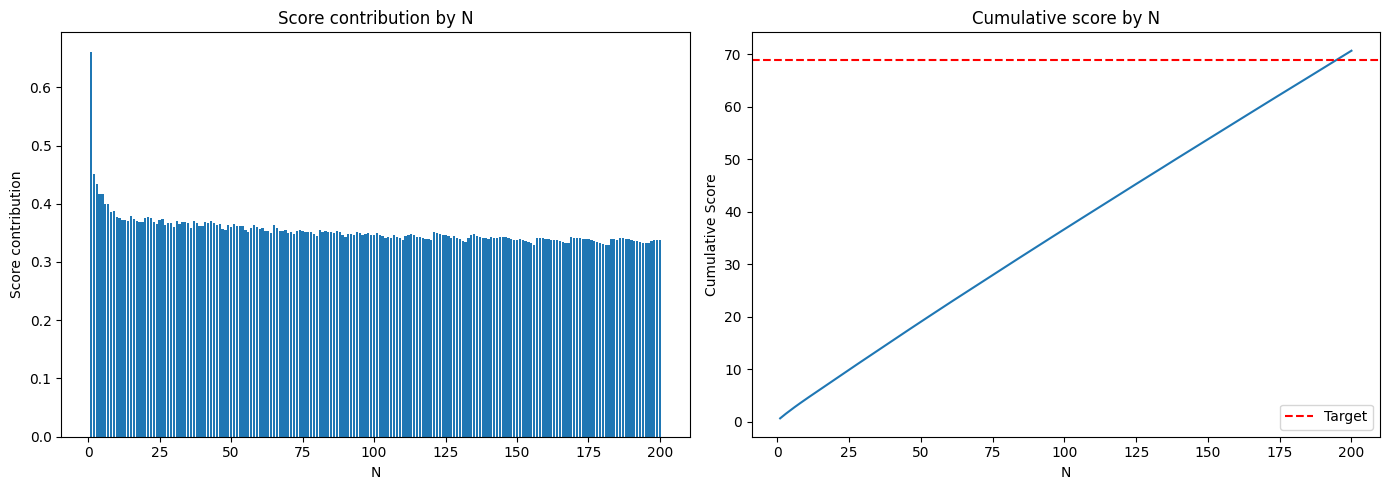

In [6]:
# Analyze score distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score by N
axes[0].bar(scores_df['N'], scores_df['score'])
axes[0].set_xlabel('N')
axes[0].set_ylabel('Score contribution')
axes[0].set_title('Score contribution by N')

# Cumulative score
scores_df['cumsum'] = scores_df['score'].cumsum()
axes[1].plot(scores_df['N'], scores_df['cumsum'])
axes[1].axhline(y=68.922808, color='r', linestyle='--', label='Target')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative score by N')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png')
plt.show()

In [7]:
# Calculate how much improvement is needed per N to reach target
target = 68.922808
current = scores_df['score'].sum()
gap = current - target

print(f'Current score: {current:.6f}')
print(f'Target: {target:.6f}')
print(f'Gap: {gap:.6f}')
print(f'Average improvement needed per N: {gap/200:.6f}')

# If we could improve the worst N values by X%, what would we get?
for pct in [5, 10, 15, 20, 25, 30]:
    # Improve top 20 worst N values by pct%
    improved = scores_df.copy()
    worst_20 = improved.nlargest(20, 'score').index
    improved.loc[worst_20, 'score'] *= (1 - pct/100)
    new_total = improved['score'].sum()
    print(f'If top 20 worst N improved by {pct}%: {new_total:.6f} (gap: {new_total - target:.6f})')

Current score: 70.676145
Target: 68.922808
Gap: 1.753337
Average improvement needed per N: 0.008767
If top 20 worst N improved by 5%: 70.272287 (gap: 1.349479)
If top 20 worst N improved by 10%: 69.868430 (gap: 0.945622)
If top 20 worst N improved by 15%: 69.464573 (gap: 0.541765)
If top 20 worst N improved by 20%: 69.060715 (gap: 0.137907)
If top 20 worst N improved by 25%: 68.656858 (gap: -0.265950)
If top 20 worst N improved by 30%: 68.253000 (gap: -0.669808)
